ELO rating of Magnus Carlsen normalized between 0 and 1:
1.0308641975308641
ELO ratings normalized between 0 and 1:
[0.94500561 0.95173962 0.93602694 0.97530864 0.9382716  1.
 0.996633   0.9298541  0.92199776 0.88215488 0.95735129 0.9640853
 0.98092031 0.96632997 0.96184063 0.91975309 0.91189675 0.96632997
 0.94949495 0.94388328 0.92031425 0.9315376  0.92648709 0.87429854
 0.98597082 0.93265993 0.89786756 0.75308642 0.93434343 0.90909091
 0.91638608 0.98035915 0.97418631 0.835578   0.94332211 0.93209877
 0.84904602 0.90796857 0.89955107 0.80920314 0.88496072 0.7687991
 0.97025814 0.81874299 0.92592593 0.91077441 0.88439955 0.85802469
 0.83838384 0.86026936 0.86195286 0.88776655 0.90179574 0.87991021
 0.89113356 0.80583614 0.82716049 0.98148148 0.82716049 0.87093154
 0.81818182 0.82659933 0.69304153 0.63468013 0.78900112 0.80246914
 0.89842873 0.80527497 0.73176207 0.80920314 0.74859708 0.74074074
 0.79854097 0.69640853 0.75925926 0.74579125 0.78451178 0.68350168
 0.94949495 0.80415264 

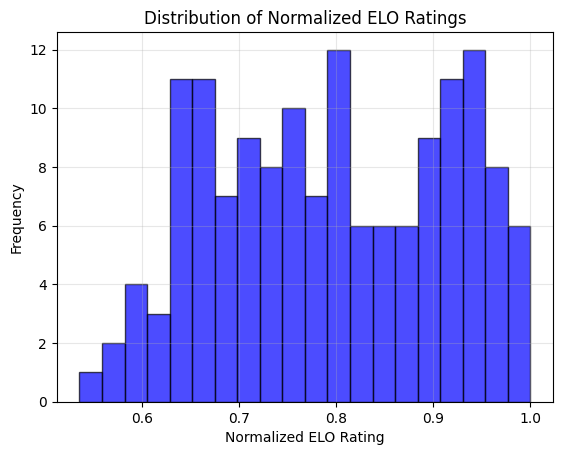

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemple de lecture depuis Excel
df = pd.read_excel("chessResultsList.xlsx")

# Drop first row and put it in another variable
first_row = df.iloc[0].copy()
df = df.drop(index=0)

elos = df["Rtg"].values

# Affichage de l'ELO du premier joueur normalisé
print("ELO rating of Magnus Carlsen normalized between 0 and 1:")
elo = first_row["Rtg"]
elo = (elo-1000) / (elos.max()-1000)
print(elo)

# Normalisation between 0 and 1
elos = (elos - 1000) / (elos.max() - 1000)

print("ELO ratings normalized between 0 and 1:")
print(elos)

# Affichage de l'histogramme
plt.hist(elos, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Normalized ELO Ratings')
plt.xlabel('Normalized ELO Rating')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Estimating the tail behavior parameter α

For a distribution with tail behavior of π(1-u) ~ Cu^α, we can estimate α by examining the log-log relationship. 
For the right tail of the distribution, we'll look at values close to 1 (since u→0 means 1-u→1).

Estimated α: 1.2440
Estimated C: 4.4120
R-squared: 0.9671


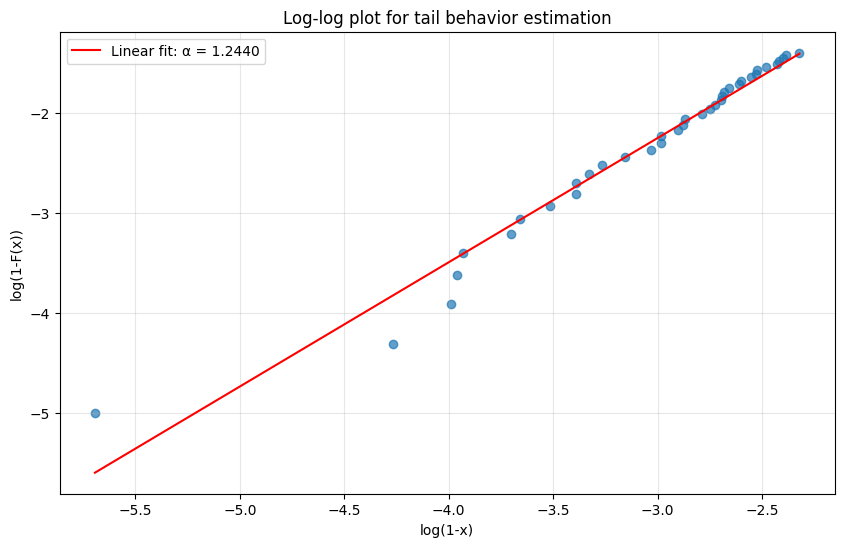

In [36]:
import numpy as np
from scipy import stats

# Sort the data in ascending order
sorted_elos = np.sort(elos)

# Create empirical CDF (F(x))
n = len(sorted_elos)
ecdf = np.arange(1, n + 1) / n

# We're interested in the upper tail: π(1-u) ~ Cu^α, where u → 0
# This means values close to the maximum (elo → 1)
# We'll use a threshold to focus on the tail (top 25% of values)
threshold = 0.75  # Focus on top 25% of the distribution
tail_indices = sorted_elos >= np.quantile(sorted_elos, threshold)

tail_elos = sorted_elos[tail_indices]
tail_ecdf = ecdf[tail_indices]

# For the upper tail, we're interested in 1-F(x)
survival = 1 - tail_ecdf

# For u→0, we look at the distance from 1: (1-x)
distance_from_max = 1 - tail_elos

# We need to exclude zero values for log transform
valid_indices = (distance_from_max > 0) & (survival > 0)
log_distance = np.log(distance_from_max[valid_indices])
log_survival = np.log(survival[valid_indices])

# Fit linear regression in log-log space
# If π(1-u) ~ Cu^α, then log(π(1-u)) ~ log(C) + α*log(u)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_distance, log_survival)

# The slope corresponds to α
alpha = slope
C = np.exp(intercept)

print(f"Estimated α: {alpha:.4f}")
print(f"Estimated C: {C:.4f}")
print(f"R-squared: {r_value**2:.4f}")

# Plot the log-log relationship
plt.figure(figsize=(10, 6))
plt.scatter(log_distance, log_survival, alpha=0.7)
plt.plot(log_distance, intercept + slope * log_distance, 'r-', 
         label=f'Linear fit: α = {alpha:.4f}')
plt.title('Log-log plot for tail behavior estimation')
plt.xlabel('log(1-x)')
plt.ylabel('log(1-F(x))')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

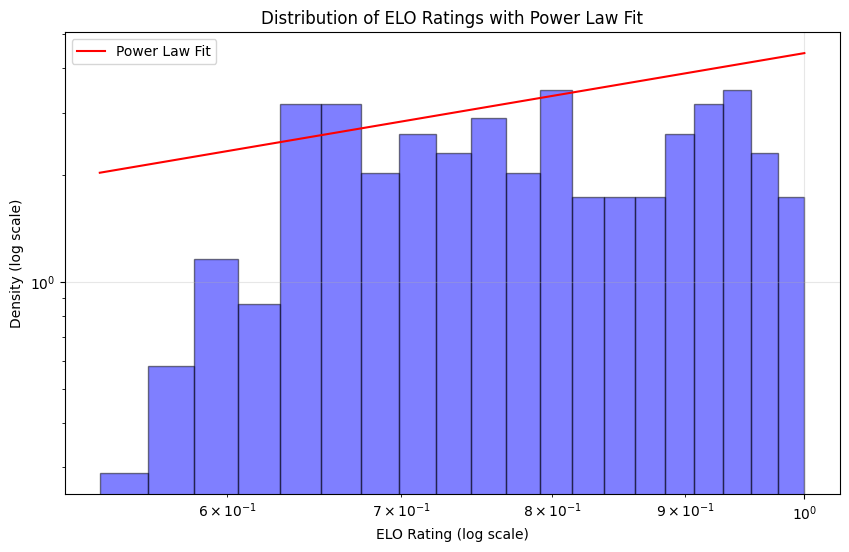

In [37]:
# Plot the distribution of elos with the fitted power law
plt.figure(figsize=(10, 6))
plt.hist(elos, bins=20, density=True, alpha=0.5, color='blue', edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of ELO Ratings with Power Law Fit')
plt.xlabel('ELO Rating (log scale)')
plt.ylabel('Density (log scale)')
plt.grid(alpha=0.3)
plt.plot(sorted_elos, C * sorted_elos**alpha, 'r-', label='Power Law Fit')
plt.legend()
plt.show()

# Verifying the Conditions of the Theorem

Let's verify the conditions of the theorem for our ELO ratings data. The theorem states that for α < 2:

- Let σ² = E[θ/(1+θ)²] denote the variance of the best player
- Let εn = √((2-α)/σ²) * √(log(n)/n)

Then:
- If lim inf(θ*n - 1)/εn > 1, then P(s* wins) → 1
- If lim sup(θ*n - 1)/εn < 1, then P(s* wins) → 0

Where θ*n represents the skill of the best player (normalized), and εn is a threshold that determines the winning probability.

Is α < 2? True
σ² = 0.245033
ε_n = 0.321883
θ*_n = 1.030864
(θ*_n - 1)/ε_n = 0.095886

According to the theorem, P(s* wins) → 0
This suggests that even the best player (Magnus Carlsen) will not consistently win.


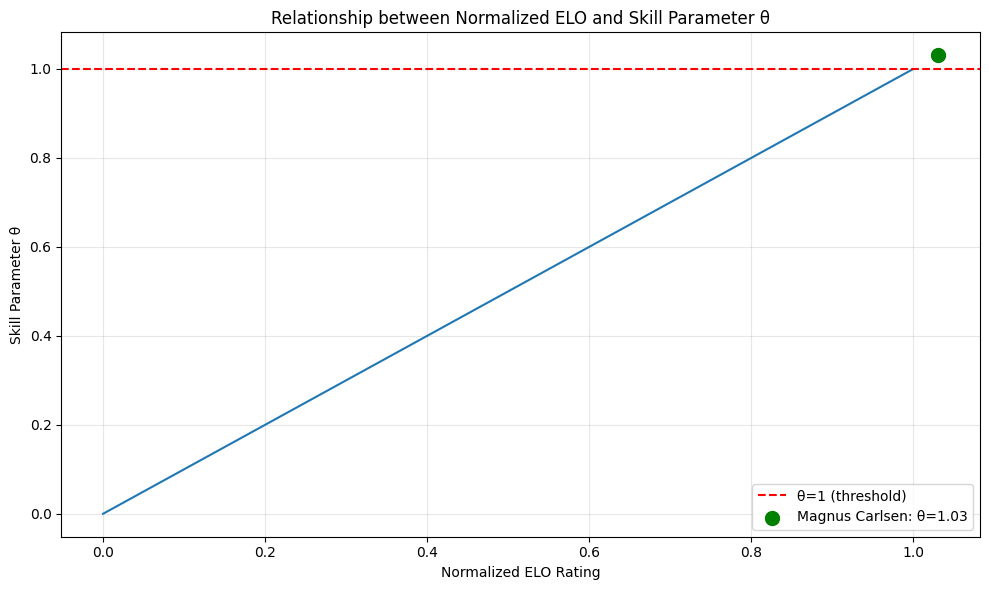

In [38]:
# First, let's confirm that our estimated α is indeed less than 2
print(f"Is α < 2? {alpha < 2}")

# Calculate the variance term σ² = E[θ/(1+θ)²]
def variance_term(theta):
    return theta / ((1 + theta) ** 2)

sigma_squared = np.mean(variance_term(sorted_elos))
print(f"σ² = {sigma_squared:.6f}")

# Calculate ε_n using the formula: εn = √((2-α)/σ²) * √(log(n)/n)
epsilon_n = np.sqrt((2 - alpha) / sigma_squared) * np.sqrt(np.log(n) / n)
print(f"ε_n = {epsilon_n:.6f}")

# Calculate (θ*_n - 1)/ε_n to check which case of the theorem applies
# θ*_n is the skill of the best player
theta_star_n = elo  # Magnus Carlsen's skill parameter
threshold_ratio = (theta_star_n - 1) / epsilon_n
print(f"θ*_n = {theta_star_n:.6f}")
print(f"(θ*_n - 1)/ε_n = {threshold_ratio:.6f}")

# Interpret the result
if threshold_ratio > 1:
    print("\nAccording to the theorem, P(s* wins) → 1")
    print("This suggests that the best player (Magnus Carlsen) will win with high probability.")
else:
    print("\nAccording to the theorem, P(s* wins) → 0")
    print("This suggests that even the best player (Magnus Carlsen) will not consistently win.")

# Visualize the relationship between θ and normalized ELO
plt.figure(figsize=(10, 6))
elo_range = np.linspace(0, 0.999, 1000)
theta_range = elo_range

plt.plot(elo_range, theta_range)
plt.axhline(y=1, color='r', linestyle='--', label='θ=1 (threshold)')
plt.scatter(elo, elo, color='green', s=100, label=f'Magnus Carlsen: θ={elo:.2f}')

plt.title('Relationship between Normalized ELO and Skill Parameter θ')
plt.xlabel('Normalized ELO Rating')
plt.ylabel('Skill Parameter θ')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()